In [1]:
#vgnet+FCN
import cv2
import os
import numpy as np
import PIL
from scipy import misc
import imageio
from time import sleep
import time
from keras.models import model_from_json
import pandas as pd
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline
import math
import datetime
import tensorflow.keras as tf
from keras.preprocessing.image import ImageDataGenerator
#import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, merge
from keras import metrics
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from tensorflow.contrib.keras import losses,optimizers,metrics
#from tensorflow.contrib.keras import layers
from keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from keras.applications import VGG19
from keras.callbacks import ModelCheckpoint
import ipdb
import h5py
from keras.layers import LeakyReLU
from keras.models import load_model
from keras.models import Model
import json
from matplotlib import pyplot as plt
import sys
sys.path
sys.executable
import operator
import queue
import pickle
from tensorflow.keras.utils import Sequence
from keras.layers import Input
%matplotlib inline
import seaborn as sn
from sklearn.metrics import classification_report
#from tensorflow.keras.applications.resnet50 import ResNet50



In [2]:
img_width, img_height = 128, 512
#img_width, img_height = 512, 512 
train_data_dir = "WOOD_PLASTIC/IMAGES_WP_25" 
#validation_data_dir = "Test_set_split" 
#test_data_dir = "Samples_3"
 
# number of epochs to train top model 
epochs = 25 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
#batch_size = 50
batch_size = 32

#Loading vgc16 model
#Last layer is removed when include_top = false
#vgg16 = applications.VGG16(include_top=False, weights='imagenet')
#resnet50=applications.ResNet50(include_top=False,weights="imagenet")
densenet121=applications.DenseNet121(include_top=False,weights="imagenet")
#datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.2, horizontal_flip = True)
#datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.2, horizontal_flip = True)
#datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.2, vertical_flip = True)
#datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.2, rotation_range=90)
datagen = ImageDataGenerator(rescale=1. / 255,validation_split=0.2,horizontal_flip = True,vertical_flip=True)
                                                 

In [3]:

############### densenet121_wood_same_param_aug_25 ########################################################################
#TRAINING######################################################################################################################
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator_train = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    subset='training',
    shuffle=False)
    
  
 
nb_train_samples = len(generator_train.filenames) 
num_classes = len(generator_train.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = densenet121.predict_generator(generator_train, predict_size_train) 
print (bottleneck_features_train.shape) 
np.save("bottleneck_features_densenet121_visual_same_param_aug_25.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)



#VALIDATION################################################################################################################
#start = datetime.datetime.now()
 
generator_val = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical',
    subset='validation',
    shuffle=False) 
print('generator_val is',generator_val)
 
nb_validation_samples = len(generator_val.filenames) 
num_classes = len(generator_val.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = densenet121.predict_generator(generator_val, predict_size_validation) 
 
np.save("bottleneck_features_validation_densenet121_visual_same_param_aug_25.npy", bottleneck_features_validation)

#training data load#################################################################################################
generator_top_train = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical',
   subset='training', 
   shuffle=False) 
 
nb_train_samples = len(generator_top_train.filenames)
print('nb_train_samples are',nb_train_samples)
num_classes = len(generator_top_train.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load("bottleneck_features_densenet121_visual_same_param_aug_25.npy") 
print (train_data.shape)
# get the class labels for the training data, in the original order 
train_labels = generator_top_train.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)


#validation data load##########################################################################################
generator_top_val = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   subset='validation', 
   shuffle=False) 
 
nb_validation_samples = len(generator_top_val.filenames) 
print('nb_validation_samples are',nb_validation_samples)
num_classes = len(generator_top_val.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load("bottleneck_features_validation_densenet121_visual_same_param_aug_25.npy") 
# get the class labels for the training data, in the original order 
validation_labels = generator_top_val.classes 
#print('validation_labels are before converting to categorical values', validation_labels )
# convert the training labels to categorical vectors 
validation_labels_converted = to_categorical(validation_labels, num_classes=num_classes)
#print('validation_labels are after converting to categorical values', validation_labels_converted )

#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential() 
#flatten output layer of orginal transfer learning model and add your own model output layers accordingly. Applies for vgg, res etc

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))##### try 0.7 dropout
model.add(Dense(num_classes, activation='softmax'))


#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])
print(model.summary())

history = model.fit(train_data, train_labels, 
          epochs=100,
          batch_size=batch_size, 
          validation_data=(validation_data, validation_labels_converted),
          validation_steps=( nb_validation_samples // batch_size))


(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels_converted, batch_size=batch_size, verbose=1)
print("[val] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[val] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)


Found 220 images belonging to 11 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
(220, 4, 16, 1024)
Time: 0:00:18.890373
Found 55 images belonging to 11 classes.
generator_val is <tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x0000020B17FA6820>
Found 220 images belonging to 11 classes.
nb_train_samples are 220
(220, 4, 16, 1024)
Found 55 images belonging to 11 classes.
nb_validation_samples are 55
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dropout (Dropout)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6553700   
_________________________________________________

Epoch 47/100
7/7 [==============================] - 0s 38ms/step - loss: 0.2183 - acc: 0.9227 - val_loss: 0.0258 - val_acc: 1.0000
Epoch 48/100
7/7 [==============================] - 0s 38ms/step - loss: 0.1487 - acc: 0.9545 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 49/100
7/7 [==============================] - 0s 37ms/step - loss: 0.1497 - acc: 0.9545 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 50/100
7/7 [==============================] - 0s 38ms/step - loss: 0.1817 - acc: 0.9591 - val_loss: 0.0202 - val_acc: 1.0000
Epoch 51/100
7/7 [==============================] - 0s 39ms/step - loss: 0.1875 - acc: 0.9409 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 52/100
7/7 [==============================] - 0s 38ms/step - loss: 0.1650 - acc: 0.9409 - val_loss: 0.0220 - val_acc: 1.0000
Epoch 53/100
7/7 [==============================] - 0s 37ms/step - loss: 0.2220 - acc: 0.9273 - val_loss: 0.0346 - val_acc: 1.0000
Epoch 54/100
7/7 [==============================] - 0s 37ms/step - loss: 0.2207 - a

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dropout (Dropout)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6553700   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

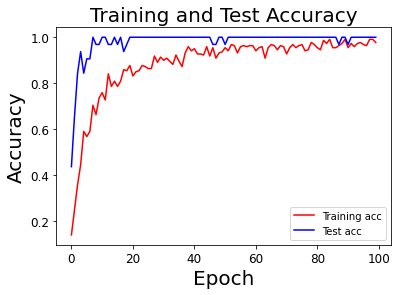

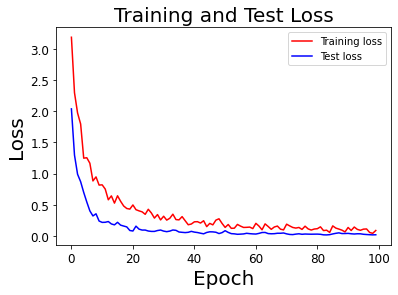

In [4]:
ax = plt.axes()
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20) 
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.tick_params(axis='both', labelsize=12)
plt.savefig("Densenet121_ACCgraph_visual_same_param_aug_25.pdf",bbox_inches='tight')
plt.savefig("Densenet121_ACCgraph_visual_same_param_aug_25.eps",bbox_inches='tight')


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and Test Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20) 
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.tick_params(axis='both', labelsize=12)
plt.savefig("Densenet121_Lossgraph_visual_same_param_aug_25.pdf",bbox_inches='tight')
plt.savefig("Densenet121_Lossgraph_visual_same_param_aug_25.eps",bbox_inches='tight')
model.save('densenet121_model_visual_same_param_aug_25.h5')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dropout (Dropout)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               6553700   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

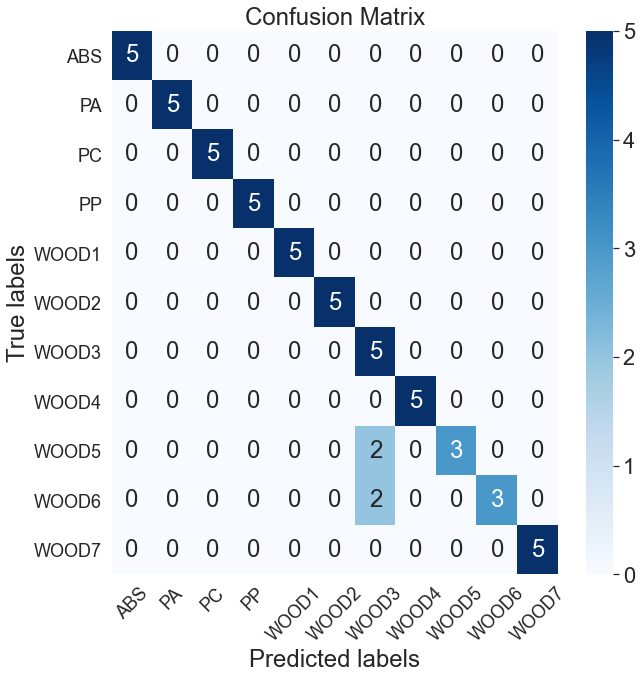

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.56      1.00      0.71         5
           7       1.00      1.00      1.00         5
           8       1.00      0.60      0.75         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5

    accuracy                           0.93        55
   macro avg       0.96      0.93      0.93        55
weighted avg       0.96      0.93      0.93        55

None


In [5]:
loaded_model = tf.keras.models.load_model('densenet121_model_visual_same_param_aug_25.h5')
loaded_model.summary()

y_pred=loaded_model.predict_generator(validation_data)
y_pred=np.argmax(y_pred, axis=1)
cm = confusion_matrix(validation_labels,y_pred)
import seaborn as sns; sns.set_theme()
sn.set(font_scale=2)
graph=plt.figure(figsize = (10,10))
classes=['ABS','PA','PC','PP','WOOD1','WOOD2','WOOD3','WOOD4','WOOD5','WOOD6','WOOD7']
ax = sn.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=True)
ax.set(title='Confusion Matrix', xlabel="Predicted labels", ylabel="True labels")
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=18)
plt.show()
graph.savefig("Densenet121_visual_same_param_25_confusion.pdf",bbox_inches='tight') ##########################################
graph.savefig("Densenet121_visual_same_param_25_confusion.eps",bbox_inches='tight')
####### generate classification report ###############################################################
report=classification_report(validation_labels, y_pred)
print(report)
report_df = pd.DataFrame([report])
print(report_df.to_csv('Densenet121_visual_same_param_25_report.csv')) 
